In [30]:
%matplotlib inline

In [14]:
import sys
sys.path.append('/Users/yaolun/programs/misc/hyperion/')
sys.path.append('/Users/yaolun/programs/spectra_analysis/')
from phot_filter import phot_filter
from get_bhr71_obs import get_bhr71_obs
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const

# constants setup
c = const.c.cgs.value

In [15]:
wl_aper = [70., 100., 160., 250., 350., 500.]

In [21]:
obs = '/Users/yaolun/bhr71/obs_for_radmc/'
bhr71 = get_bhr71_obs(obs)
wave_obs, flux_obs, sed_obs_noise = bhr71['spec']

# add IRAC1 and IRAC2 photometry data
wave_obs = np.hstack((wave_obs, bhr71['phot'][0][0:2]))
flux_obs = np.hstack((flux_obs, bhr71['phot'][1][0:2]))
sed_obs_noise = np.hstack((sed_obs_noise, bhr71['phot'][2][0:2]))
# wave_obs = wave_obs[wave_obs > 50]
# flux_obs = flux_obs[wave_obs > 50]
sed_obs = c/(wave_obs*1e-4)*flux_obs*1e-23
sed_obs_noise = c/(wave_obs*1e-4)*sed_obs_noise*1e-23
# print sed_obs_noise
obs_aper_sed = np.empty_like(wl_aper)
obs_aper_sed_noise = np.empty_like(wl_aper)

# sort the wavelength
sed_obs = sed_obs[np.argsort(wave_obs)]
sed_obs_noise = sed_obs_noise[np.argsort(wave_obs)]
wave_obs = wave_obs[np.argsort(wave_obs)]

# calculate the spectrophotometry
for i in range(0, len(wl_aper)):
    # apply the filter function
    # decide the filter name
    if wl_aper[i] == 70:
        fil_name = 'Herschel PACS 70um'
    elif wl_aper[i] == 100:
        fil_name = 'Herschel PACS 100um'
    elif wl_aper[i] == 160:
        fil_name = 'Herschel PACS 160um'
    elif wl_aper[i] == 250:
        fil_name = 'Herschel SPIRE 250um'
    elif wl_aper[i] == 350:
        fil_name = 'Herschel SPIRE 350um'
    elif wl_aper[i] == 500:
        fil_name = 'Herschel SPIRE 500um'
    elif wl_aper[i] == 3.6:
        fil_name = 'IRAC Channel 1'
    elif wl_aper[i] == 4.5:
        fil_name = 'IRAC Channel 2'
    elif wl_aper[i] == 5.8:
        fil_name = 'IRAC Channel 3'
    elif wl_aper[i] == 8.0:
        fil_name = 'IRAC Channel 4'
    elif wl_aper[i] == 24:
        fil_name = 'MIPS 24um'
    # elif wl_aper[i] == 850:
    #     fil_name = 'SCUBA 850WB'
    # do not have SCUBA spectra
    else:
        fil_name = None

    if fil_name != None:
        filter_func = phot_filter(fil_name)
        # Observed SED needs to be trimmed before applying photometry filters
        filter_func = filter_func[(filter_func['wave']/1e4 >= min(wave_obs))*\
                                  ((filter_func['wave']/1e4 >= 54.8)+(filter_func['wave']/1e4 <= 36.0853))*\
                                  ((filter_func['wave']/1e4 <= 95.05)+(filter_func['wave']/1e4 >=103))*\
                                  ((filter_func['wave']/1e4 <= 190.31)+(filter_func['wave']/1e4 >= 195))*\
                                  (filter_func['wave']/1e4 <= max(wave_obs))]
        f = interp1d(wave_obs, sed_obs)
        f_unc = interp1d(wave_obs, sed_obs_noise)
        obs_aper_sed[i] = np.trapz(filter_func['wave']/1e4, f(filter_func['wave']/1e4)*filter_func['transmission'])/np.trapz(filter_func['wave']/1e4, filter_func['transmission'])
        obs_aper_sed_noise[i] = abs(np.trapz((filter_func['wave']/1e4)**2, (f_unc(filter_func['wave']/1e4)*filter_func['transmission'])**2))**0.5 / abs(np.trapz(filter_func['wave']/1e4, filter_func['transmission']))
    else:
        # use a rectangle function the average the simulated SED
        # apply the spectral resolution
        if (wl_aper[i] < 50.) & (wl_aper[i] >= 5):
            res = 60.
        elif wl_aper[i] < 5:
            res = 10.
        else:
            res = 1000.
        ind = np.where((wave_obs < wl_aper[i]*(1+1./res)) & (wave_obs > wl_aper[i]*(1-1./res)))
        if len(ind[0]) != 0:
            obs_aper_sed[i] = np.mean(sed_obs[ind])
            obs_aper_sed_noise[i] = np.mean(sed_obs_noise[ind])
        else:
            f = interp1d(wave_obs, sed_obs)
            f_unc = interp1d(wave_obs, sed_obs_noise)
            obs_aper_sed[i] = f(wl_aper[i])
            obs_aper_sed_noise[i] = f_unc(wl_aper[i])

In [26]:
# convert Jy to erg/s/cm2 (photometry)
sed_phot = c/(bhr71['phot'][0]*1e-4)*bhr71['phot'][1]*1e-23
sed_phot_noise = c/(bhr71['phot'][0]*1e-4)*bhr71['phot'][2]*1e-23

In [38]:
print np.shape(bhr71['phot'][0][-6:])
print np.shape(sed_phot)

(6,)
(15,)


5.4262434898e-09 1.19979885803e-10 3.13201373335e-10
7.19801691658e-09 1.18167837863e-10 4.12036508434e-10
4.92409112265e-09 6.59061990266e-11 2.92444780391e-10
2.9379660884e-09 2.32396969896e-11 1.57114005884e-10
9.9616751044e-10 1.00841571018e-11 5.12099633271e-11
2.51226079804e-10 2.45603560812e-12 1.50841947423e-11


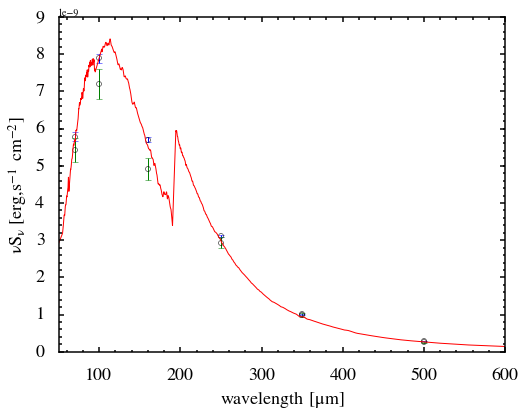

In [62]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.errorbar(wl_aper, obs_aper_sed, yerr=obs_aper_sed_noise, fmt='o', mfc='None', markersize=5)
yerr = ( (obs_aper_sed*0.05)**2 + obs_aper_sed_noise**2 )**0.5
for i in range(0,6):
    print sed_phot[-6:][i], obs_aper_sed_noise[i], yerr[i]
ax.errorbar(bhr71['phot'][0][-6:], sed_phot[-6:], yerr=yerr, fmt='o', mfc='None', markersize=5)
ax.plot(bhr71['spec'][0], c/(bhr71['spec'][0]*1e-4)*bhr71['spec'][1]*1e-23)
ax.set_xlim([50,600])

[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on() 
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)
ax.set_xlabel(r'$\rm{wavelength\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{\nu S_{\nu}\,[erg,s^{-1}\,cm^{-2}]}$', fontsize=18)

fig.savefig('/Users/yaolun/test/bhr71_herschel.pdf', format='pdf', dpi=300, bbox_inches='tight')